In [98]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt

# Load data
data_path = os.path.join('20231110_lifetime_data.h5')
data = {}
with h5py.File(data_path, 'r') as f:
    print('Available datasets:', list(f.keys()))
    for key in f.keys():
        data[key] = {}
        for k in f[key].keys():
            data[key][k] = f[key][k][:]

Available datasets: ['BPM_sum_C15-P1', 'BPM_sum_C15-P2', 'BPM_sum_C15-P3', 'BPM_sum_C15-P4', 'BPM_sum_C15-P5', 'BPM_sum_C15-P6', 'DCCT_1', 'DCCT_2', 'DCCT_precise', 'eps_x', 'eps_y', 'tau_BPM_sum', 'tau_DCCT']


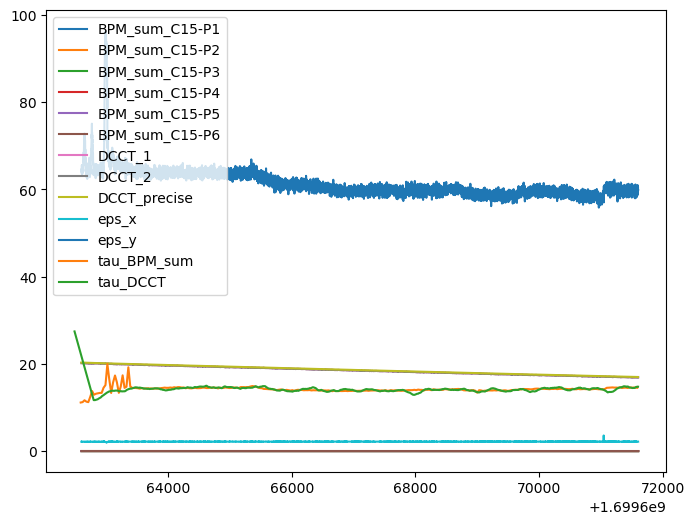

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for k,v in data.items():
    ax.plot(v['timestamps'], v['vals'], label=k)
ax.legend()

Text(0, 0.5, 'Normalized signal')

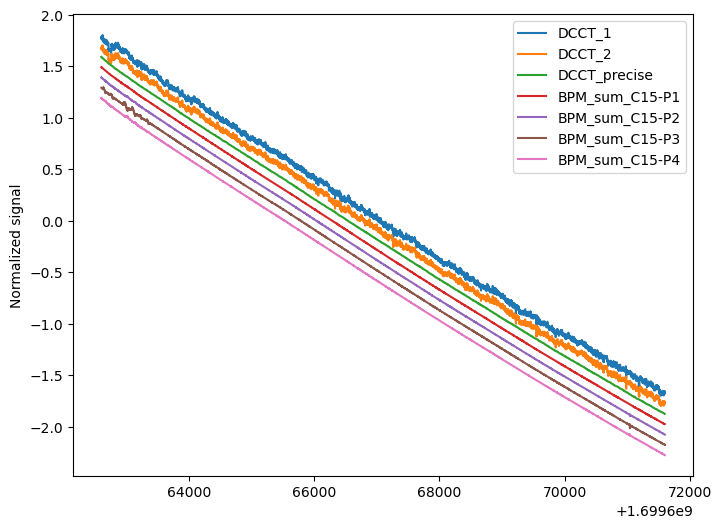

In [100]:
dccts = ['DCCT_1', 'DCCT_2', 'DCCT_precise','BPM_sum_C15-P1','BPM_sum_C15-P2','BPM_sum_C15-P3','BPM_sum_C15-P4']

# Normalized signals
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i,k in enumerate(dccts):
    v = data[k]
    y = v['vals']
    ynorm = (y-y.mean())/y.std()
    ax.plot(v['timestamps'], ynorm-i*0.1, label=k)
    #ax.plot(v['timestamps'], y, label=k)
ax.legend()
ax.set_ylabel('Normalized signal')

In [101]:
from sklearn.linear_model import ARDRegression, BayesianRidge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_data_around_t(x,y,start,end):
    xs = (x > start) & (x < end)
    return x[xs], y[xs]

def slope(data_array):
    X = data_array[:, 0].reshape(-1, 1)
    #X = X - X[0,0]
    y = data_array[:, 1].reshape(-1, 1)
    linear_model = LinearRegression()
    model = linear_model.fit(X, y)
    slope = model.coef_[0]
    return slope, model

### Compute lifetime over whole study

In [102]:
t_start = data['DCCT_precise']['timestamps'][0] + 60
t_end = data['DCCT_precise']['timestamps'][-1]

In [103]:
lifetime_data = {k:[] for k in dccts}
times = []
print(t_start, t_end-61, (t_end-t_start)/61)
for t1 in np.arange(t_start, t_end-61, 61):    
    for i,k in enumerate(dccts):
        x,y = data[k]['timestamps'], data[k]['vals']
        x,y = get_data_around_t(x,y,t1,t1+31)
        XYvec = np.hstack([x[:,None],y[:,None]])
        lt = -slope(XYvec)[0] * 60 * 60 * 24 * 2/ y.mean()
        lifetime_data[k].append(lt)
    times.append(t1+15.5)

lifetime_data = {k:np.array(v).flatten() for k,v in lifetime_data.items()}

1699662657.401809 1699671536.392678 146.55722736139768


(0.0, 15.0)

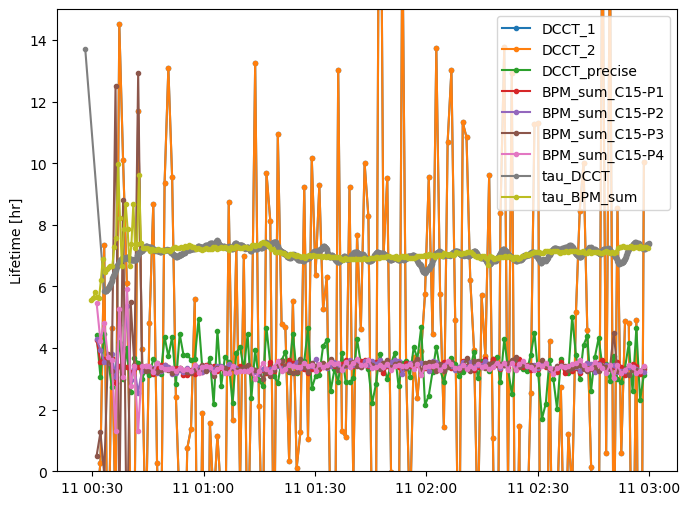

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i,k in enumerate(dccts):
    x,y = np.array(times), lifetime_data[k]
    ax.plot(x.astype(np.datetime64), y, label=k, marker='.')
ax.plot(data['tau_DCCT']['timestamps'].astype(np.datetime64), data['tau_DCCT']['vals']/2, label='tau_DCCT', marker='.')
ax.plot(data['tau_BPM_sum']['timestamps'].astype(np.datetime64), data['tau_BPM_sum']['vals']/2, label='tau_BPM_sum', marker='.')
ax.legend()
ax.set_ylabel('Lifetime [hr]')
ax.set_ylim(0, 15)

### Look at small chunk

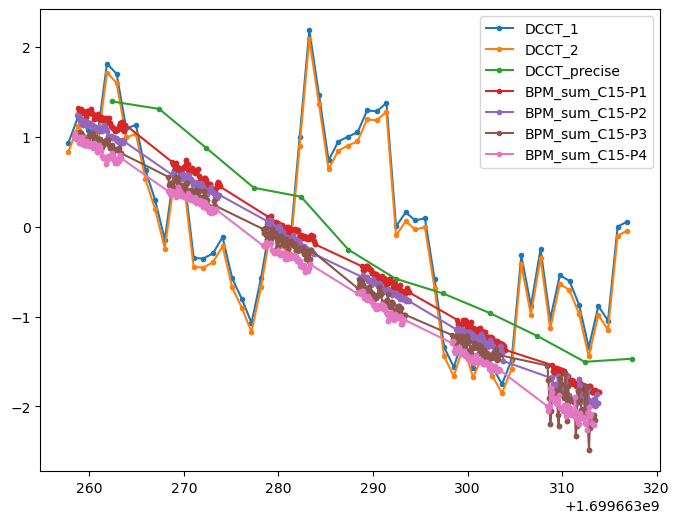

In [105]:
t1,t2 = t_start + 600, t_start + 660

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i,k in enumerate(dccts):
    x,y = data[k]['timestamps'], data[k]['vals']
    x,y = get_data_around_t(x,y,t1,t2)
    ynorm = (y-y.mean())/y.std()
    ax.plot(x, ynorm-i*0.1, label=k, marker='.')
ax.legend()

In [106]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)])[0] for _ in range(replicates)])
    return resample_estimates

In [107]:
slopes = {}
for i,k in enumerate(dccts):
    x,y = data[k]['timestamps'], data[k]['vals']
    x,y = get_data_around_t(x,y,t1,t2)
    XYvec = np.hstack([x[:,None],y[:,None]])
    slope_samples = bootstrap(XYvec, slope)
    slopes[k] = -slope_samples * 60 * 60 * 24 * 2 / y.mean()

(10.0, 18.0)

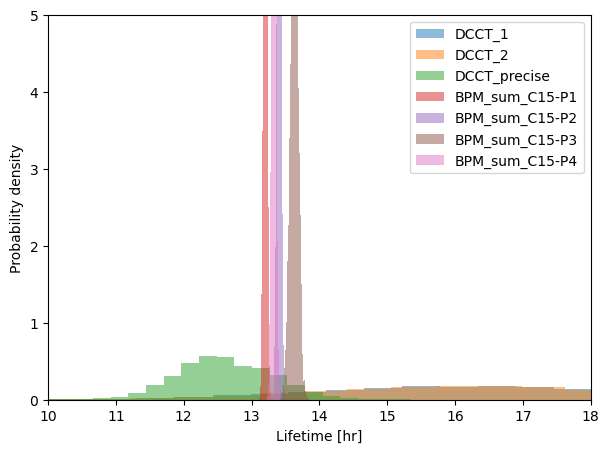

In [109]:
fig, ax = plt.subplots(1,1,figsize = (7, 5))
for i,k in enumerate(dccts):
    ax.hist(slopes[k] * 4, bins=30, density=True, alpha=0.5, label=k);
ax.set_ylabel('Probability density')
ax.set_xlabel('Lifetime [hr]')
ax.legend()
ax.set_ylim(0,5)
ax.set_xlim(10,18)

### Try normalizing

In [202]:
all_cols = ['BPM_sum_C15-P1', 'BPM_sum_C15-P2', 'BPM_sum_C15-P3', 'BPM_sum_C15-P4', 'BPM_sum_C15-P5', 'BPM_sum_C15-P6', 'DCCT_1', 'DCCT_2', 'DCCT_precise', 'eps_x', 'eps_y', 'tau_BPM_sum', 'tau_DCCT']

lifetime_data = {k:[] for k in all_cols}
avg_data = {k:[] for k in all_cols}
times = []
print(t_start, t_end-61, (t_end-t_start)/61)
for t1 in np.arange(t_start+1800, t_end-61-600, 20):    
    for i,k in enumerate(all_cols):
        x,y = data[k]['timestamps'], data[k]['vals']
        x,y = get_data_around_t(x,y,t1,t1+61)
        if k in dccts:            
            XYvec = np.hstack([x[:,None],y[:,None]])
            lt = -slope(XYvec)[0] * 60 * 60 * 24 * 2/ y.mean()
            lifetime_data[k].append(lt)
        avg_data[k].append(y.mean())
    times.append(t1+15.5)

lifetime_data = {k:np.array(v).flatten() for k,v in lifetime_data.items()}
avg_data = {k:np.array(v).flatten() for k,v in avg_data.items()}

1699662657.401809 1699671536.392678 146.55722736139768


In [214]:
coupling =  (np.sqrt(data['eps_y']['vals'].mean()/(data['eps_x']['vals'].mean()*1000))) / (np.sqrt(avg_data['eps_y']/(avg_data['eps_x']*1000)))
beam_volume = (data['eps_y']['vals'].mean() * (data['eps_x']['vals'].mean()*1000)) / (avg_data['eps_y'] * (avg_data['eps_x']*1000))

In [217]:
DCCT = 'DCCT_Precise'
coupling_ = avg_data['tau_BPM_sum'] * coupling
volume_ = avg_data['tau_BPM_sum'] * beam_volume
current_coupling = avg_data['tau_BPM_sum'] * coupling * avg_data[DCCT] / 20
current_23_coupling = avg_data['tau_BPM_sum'] * coupling * (avg_data[DCCT] / 20)**(2/3)
current_23 = avg_data['tau_BPM_sum'] * (avg_data[DCCT] / 20)**(2/3)
current = avg_data['tau_BPM_sum'] * (avg_data[DCCT] / 20)
current_23_volume = avg_data['tau_BPM_sum'] * beam_volume * (avg_data[DCCT] / 20)**(2/3)

(12.0, 16.0)

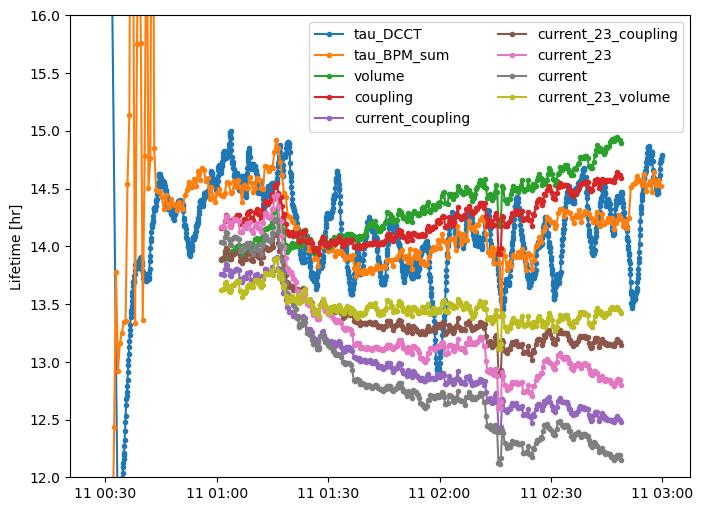

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x,y = np.array(times).astype(np.datetime64), lifetime_data['BPM_sum_C15-P1']

#ax.plot(x.astype(np.datetime64), y*2, label='BPM_sum_C15-P1', marker='.')
ax.plot(data['tau_DCCT']['timestamps'].astype(np.datetime64), data['tau_DCCT']['vals'], label='tau_DCCT', marker='.')
ax.plot(data['tau_BPM_sum']['timestamps'].astype(np.datetime64), data['tau_BPM_sum']['vals'], label='tau_BPM_sum', marker='.')
#ax.plot(data['tau_BPM_sum']['timestamps'].astype(np.datetime64), data['tau_BPM_sum']['vals']/2, label='tau_BPM_sum', marker='.')
ax.plot(x, volume_, label='volume', marker='.')
ax.plot(x, coupling_, label='coupling', marker='.')
ax.plot(x, current_coupling, label='current_coupling', marker='.')
ax.plot(x, current_23_coupling, label='current_23_coupling', marker='.')
ax.plot(x, current_23, label='current_23', marker='.')
ax.plot(x, current, label='current', marker='.')
ax.plot(x, current_23_volume, label='current_23_volume', marker='.')
ax.legend(ncol=2)
ax.set_ylabel('Lifetime [hr]')
ax.set_ylim(12, 16)

In [56]:
brr = make_pipeline(
    StandardScaler(),
    BayesianRidge(compute_score=True),
).fit(Xvec, y)
brr = BayesianRidge(compute_score=True).fit(Xvec, y)

In [59]:
brr.coef_, brr.lambda_, brr.sigma_

(array([-0.00050054]), 444260.47656643786, array([[3.92343572e-10]]))

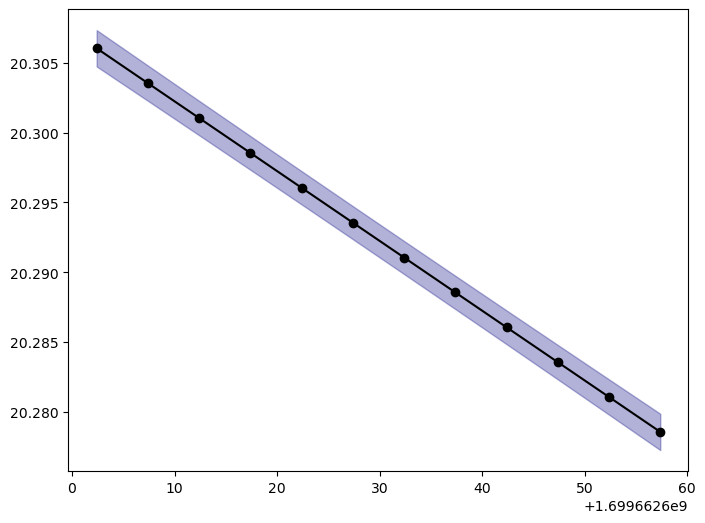

In [51]:
import seaborn as sns
# ax = sns.scatterplot(
#     data=full_data, x="input_feature", y="target", color="black", alpha=0.75
# )
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x[:,None], Yp, color="black", marker='o', label="Ground Truth")
ax.fill_between(
    x[:,None].ravel(),
    Yp - Ypstd,
    Yp + Ypstd,
    color="navy",
    alpha=0.3,
)

In [ ]:
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    df.T,
    norm=SymLogNorm(linthresh=10e-4, vmin=-80, vmax=80),
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (7, 5))
ax.hist(-(theta_hat_sampling/24.3) * 60 * 60 * 24 *2, bins=30,density=True, alpha=0.5, label='DCCT')
ax.hist(-(sampling_bcm/24.3) * 60 * 60 * 24 *2, bins=30,density=True, alpha=0.5, label='BCM')
ax.set_xlabel("Lifetime [hr]")
ax.set_ylabel("Sample density")
ax.legend()